In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

/home/kk/dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
x_valid = x_train[train_num:-1]
x_train = x_train[0:train_num]

In [4]:
#encoder part
x = Input(shape=(28,28,1))
def add_noise(arg):
    mask=np.zeros((28,28,1))
    for i in range(30):  
        row = np.random.randint(0, 28)  
        col = np.random.randint(0, 28)
        mask[row, col,0] = np.random.normal(0.5, 0.3,1)
        mask[row, col,0] = max(mask[row, col,0],0)
        mask[row, col,0] = min(mask[row, col,0],1)
    return arg + mask
x_noise = Lambda(add_noise,output_shape=(28,28,1))(x)
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [5]:
#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_decoder = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28


# instantiate VAE model
vae = Model(x, x_decoder)
noiseimg=Model(x,x_noise)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   640         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [6]:
# Compute VAE loss
x_in=Reshape([original_dim,])(x)
x_out=Reshape([original_dim,])(x_decoder)
xent_loss = original_dim * metrics.binary_crossentropy(x_in, x_out)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam', loss='')

/home/kk/dl/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Output "conv2d_transpose_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_8" during training.
  if __name__ == '__main__':


In [7]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_valid, None))

Train on 50000 samples, validate on 9999 samples
Epoch 1/10
50000/50000 [==============================] - 49s 984us/step - loss: 231.6715 - val_loss: 167.1643
Epoch 2/10
50000/50000 [==============================] - 45s 906us/step - loss: 143.9345 - val_loss: 130.3945
Epoch 3/10
50000/50000 [==============================] - 45s 903us/step - loss: 126.0801 - val_loss: 123.3068
Epoch 4/10
50000/50000 [==============================] - 45s 906us/step - loss: 120.8234 - val_loss: 118.8405
Epoch 5/10
50000/50000 [==============================] - 45s 907us/step - loss: 118.0472 - val_loss: 117.2233
Epoch 6/10
50000/50000 [==============================] - 45s 907us/step - loss: 116.1513 - val_loss: 115.2363
Epoch 7/10
50000/50000 [==============================] - 45s 906us/step - loss: 114.9865 - val_loss: 114.1060
Epoch 8/10
50000/50000 [==============================] - 45s 909us/step - loss: 113.8773 - val_loss: 113.2406
Epoch 9/10
50000/50000 [==============================] - 45s 9

In [8]:
n = 6  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n))
xout=vae.predict(x_test[0:batch_size])

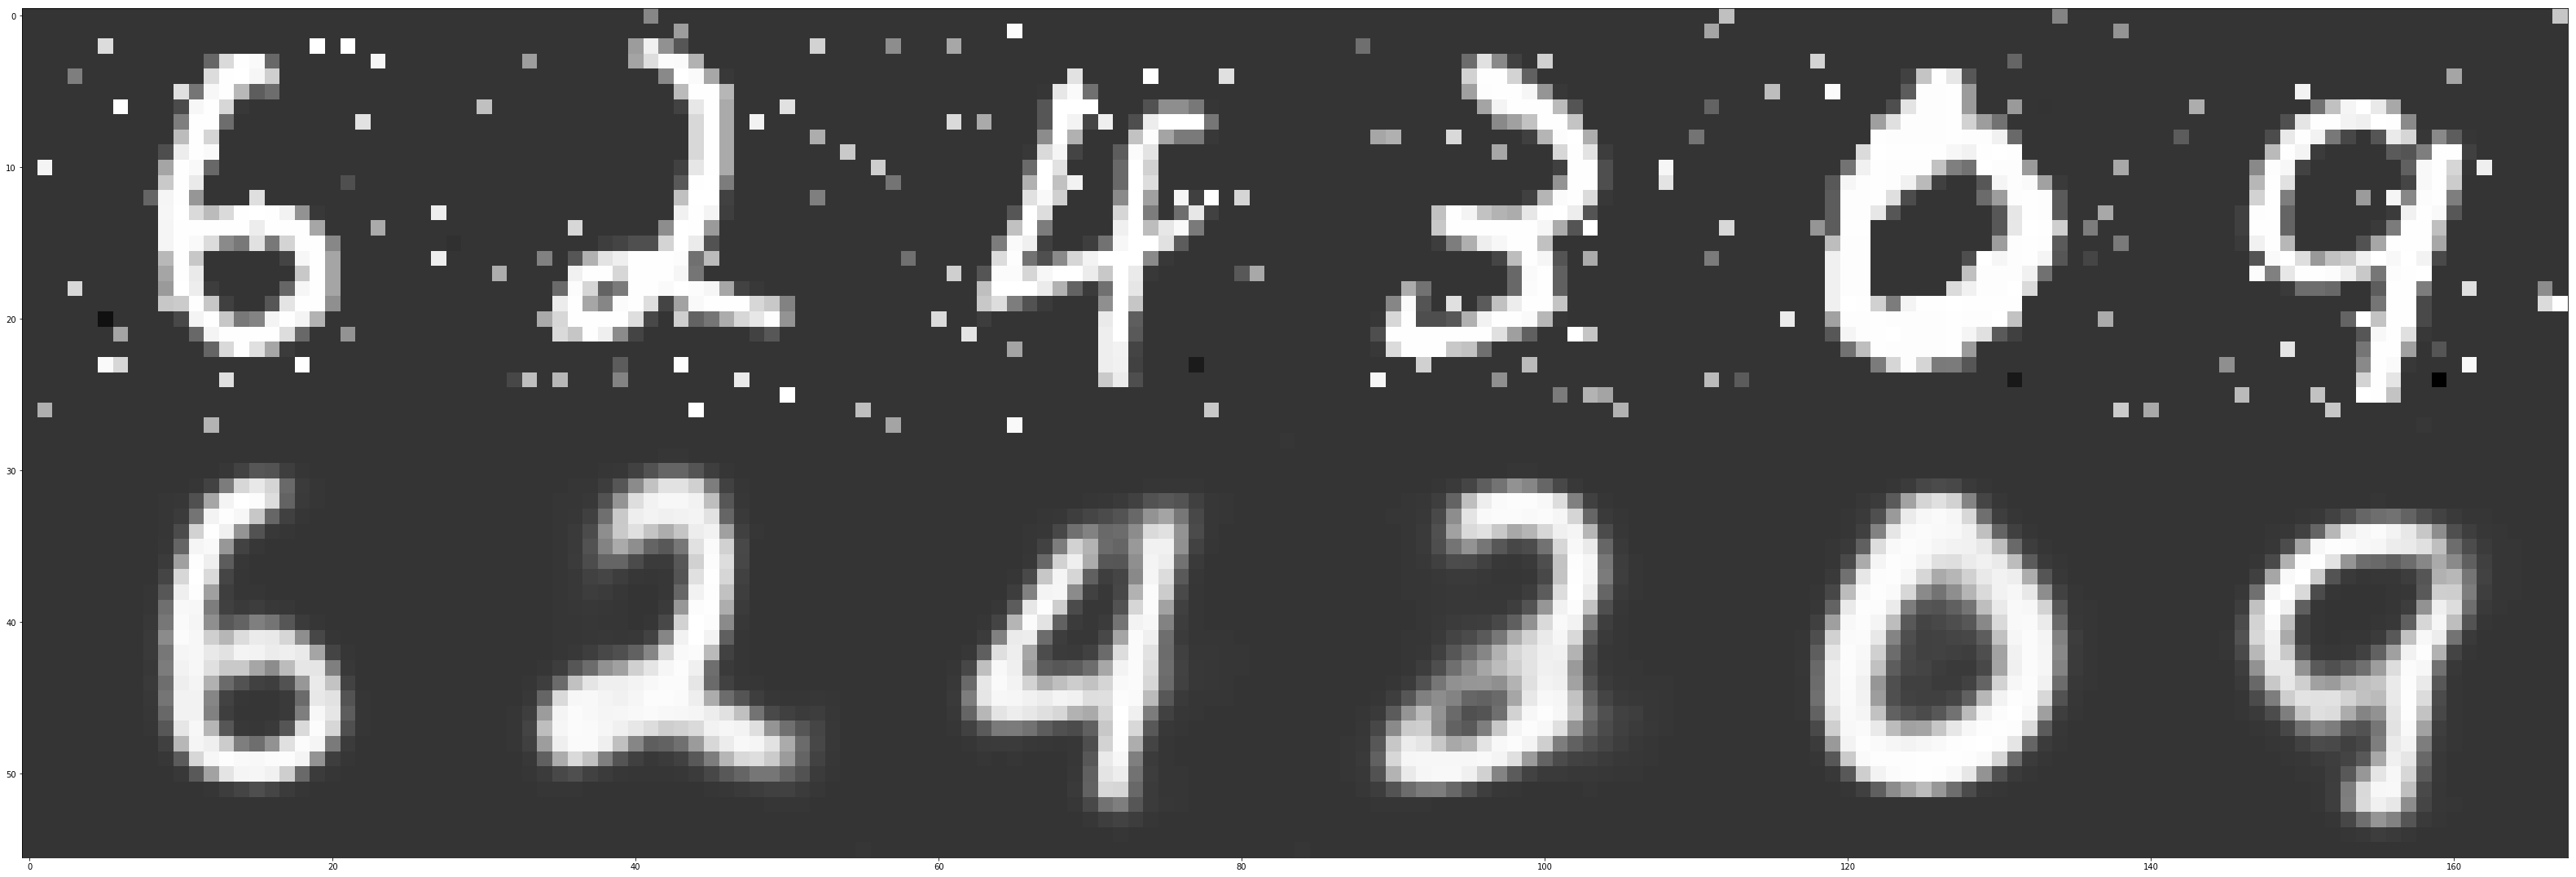

In [9]:
def add_noise2(arg):
    mask=np.zeros((28,28,1))
    for i in range(30):  
        row = np.random.randint(0, 28)  
        col = np.random.randint(0, 28)
        mask[row, col,0] = min(np.random.normal(0.5, 0.3,1),1-arg[row, col,0])        
    return arg + mask
showidx=np.random.randint(0,batch_size,n)
for i,idx in enumerate (showidx):
    figure[0: 28,i * digit_size: (i + 1) * digit_size] = add_noise2(x_test[idx]).reshape(28,28)
    temp=xout[idx].reshape(28,28)
    figure[28: 56,i * digit_size: (i + 1) * digit_size] = temp/np.max(temp) 
plt.figure(figsize=(digit_size*2, digit_size*n))
plt.imshow(figure, cmap='Greys_r')
plt.show()